In [720]:
#GAIA name according to http://www.astronomerstelegram.org/?read=13346 GAIA DR2 2891196718939580672

#check at TASOC
#Get TIC 143169638

#https://tasoc.dk/catalog/143169638
#Tmag = 12.3943

#Observed in Sector 6 
#According to WTV: Dec11 2018 to Jan17 2019 corresponds to MJD 58463 to MJD 58490

In [721]:
import numpy as np
#from astropy.io import fits
#import requests
from astroquery.mast import Catalogs
#import zipfile
#from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline

#urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"

# lightkurve

In [722]:
import lightkurve as lk
search_result = lk.search_tesscut('TIC 143169638')
search_result

SearchResult containing 1 data products.

 target_name  productFilename        description         distance
------------- --------------- -------------------------- --------
TIC 143169638             n/a TESS FFI Cutout (sector 6)      0.0

In [723]:
tpf = search_result.download(cutout_size=14)

1% (6/993) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [724]:
target_mask = tpf.create_threshold_mask(threshold=12, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

3

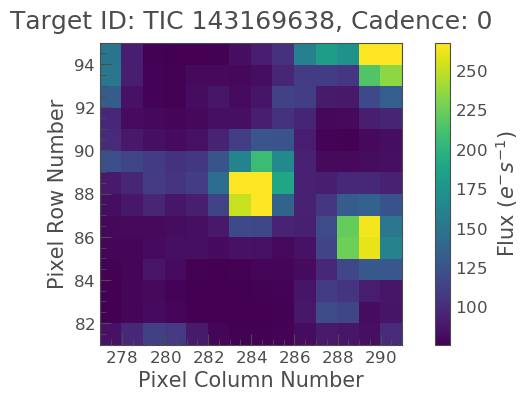

In [725]:
tpf.plot();

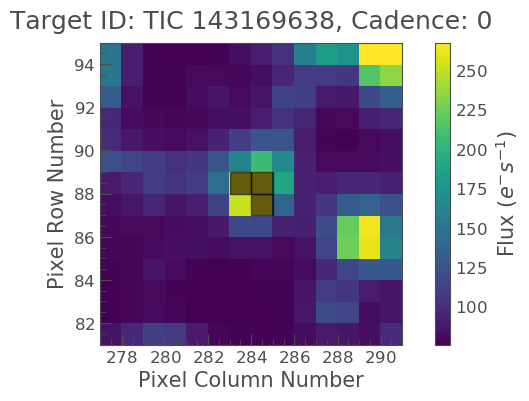

In [726]:
tpf.plot(aperture_mask=target_mask, mask_color='k');

In [727]:
#Check closest stars
ticid = 762075900
starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees --> 5 arcmins

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

# Print out the first five rows in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType', 'GAIA'] )

#Double check GAIA number: 2891196718939580672
#is correct

    ID      Tmag   Jmag  ...       dec        objType         GAIA       
--------- ------- ------ ... ---------------- ------- -------------------
762075900 14.4944     -- ... 15.8326624241943    STAR 3167924279316997760
 14448233  9.3069  9.112 ... 15.8320013016406    STAR 3167924275021925248
 14448232 18.9715 16.381 ... 15.8303658038958    STAR 3167924244957261312
 14448234 18.0353 16.516 ... 15.8339057266803    STAR 3167924206302365824
 14448240 15.8059 14.457 ... 15.8381854547107    STAR 3167924279319417344


In [728]:
#You need tess-point for that
#pip install tess-point
#see: https://github.com/christopherburke/tess-point
!python -m tess_stars2px -t 143169638

#last two entries are the position in pixels

# TIC     |   RA      |   Dec     | EclipticLong | EclipticLat | Sector | Camera | Ccd | ColPix | RowPix
143169638 |  90.003155 | -31.007731 |  90.000790 | -54.448615 |  6 | 3 | 2 |  284.720 |   88.046


In [729]:
x_pix = 284.720
y_pix = 88.046

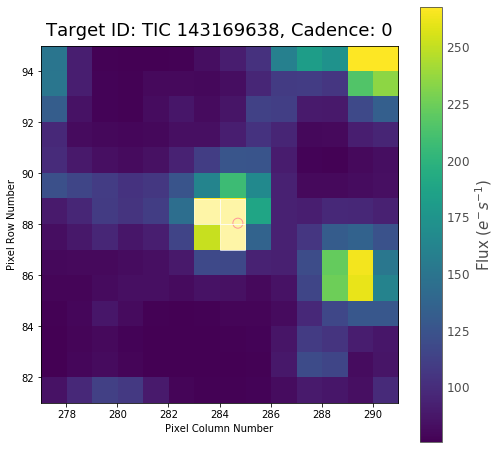

In [730]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.scatter(x_pix, y_pix, marker='o', s=100, facecolor='', edgecolor='r', )
tpf.plot(aperture_mask=target_mask, mask_color='w', ax=ax, );

# Simple background subtraction

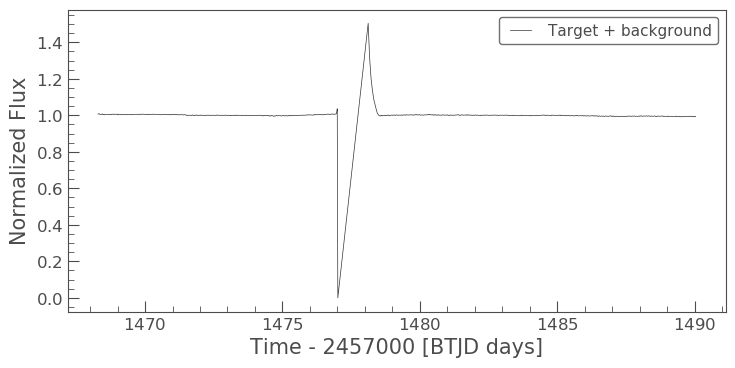

In [733]:
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)
target_lc.plot(label='Target + background');

In [734]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0001, reference_pixel=None)

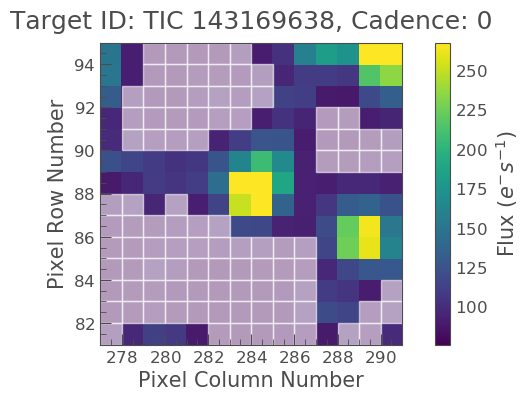

In [735]:
tpf.plot(aperture_mask=background_mask, mask_color='w');

In [736]:
n_background_pixels = background_mask.sum()
n_background_pixels

98

In [737]:
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels

In [738]:
background_estimate_lc = background_lc_per_pixel * n_target_pixels

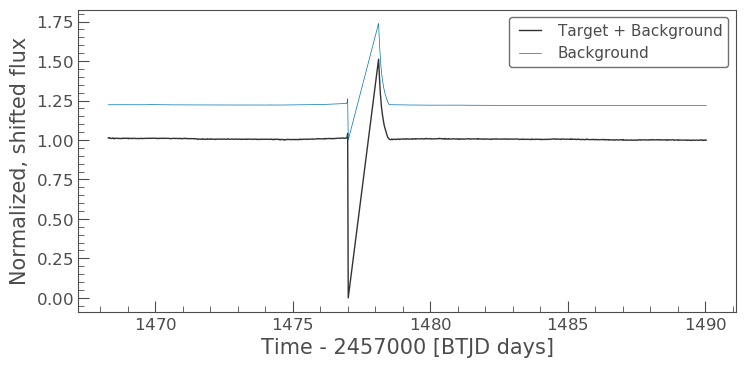

In [739]:
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');

In [740]:
corrected_lc = target_lc - background_estimate_lc.flux

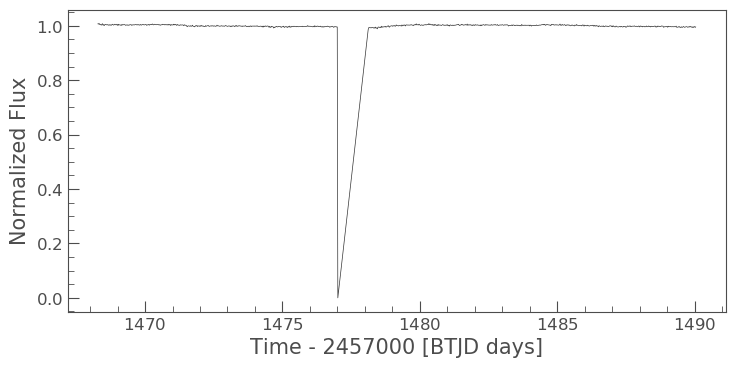

In [741]:
corrected_lc.plot();

In [742]:
#sector edges
edge1 = 1477.01998-0.1
edge2 =  1478.11304+0.1

In [743]:
#remove a bit around orbit edges
edge_mask = (corrected_lc.time < edge1)| (edge2 < corrected_lc.time)

In [744]:
#momentum dumps in sec 6

#momentum dump times for sector 6
mom_dumps2 = [1468.3747569443658,
   1471.4997569443658,
   1474.6247569443658,
   1481.2705902778544,
   1484.395578703843,
   1487.520578703843]

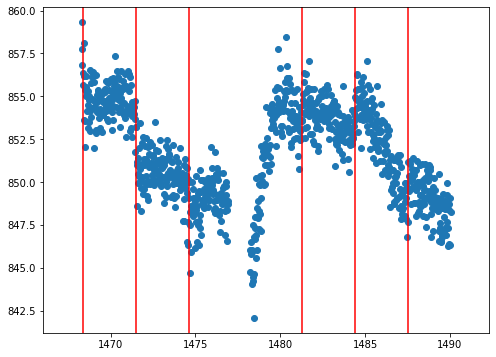

In [745]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

[ax.axvline(i,c='r') for i in mom_dumps2]
ax.scatter(corrected_lc.time[edge_mask],corrected_lc.flux[edge_mask])

In [753]:
# nothing interesting to see in the plot. Let's try other methods

# eleanor

In [754]:
# Try out eleanor
import eleanor

In [755]:
ticid = 143169638

In [756]:
star = eleanor.Source(tic=ticid, sector=6, tc=True)

In [757]:
star.coords

[90.0031547818751, -31.0077314028401]

In [758]:
star.position_on_chip

array([268,  72])

In [759]:
data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=False, do_pca=False)

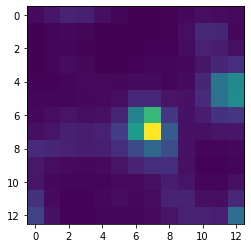

In [760]:
plt.imshow(data.tpf[0])

## aperture by eleanor

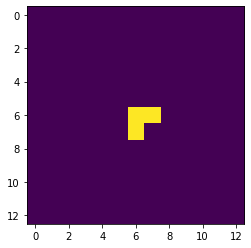

In [761]:
plt.imshow(data.aperture)

In [762]:
data.aperture

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

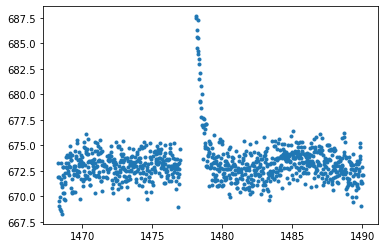

In [763]:
q = (data.quality == 0)
plt.plot(data.time[q], data.corr_flux[q], '.')
lc_el = lk.LightCurve(data.time[q], data.corr_flux[q])

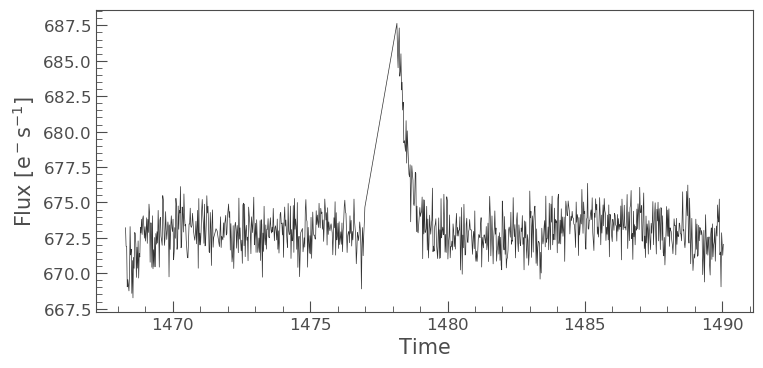

In [764]:
lc_el.plot(normalize=False)

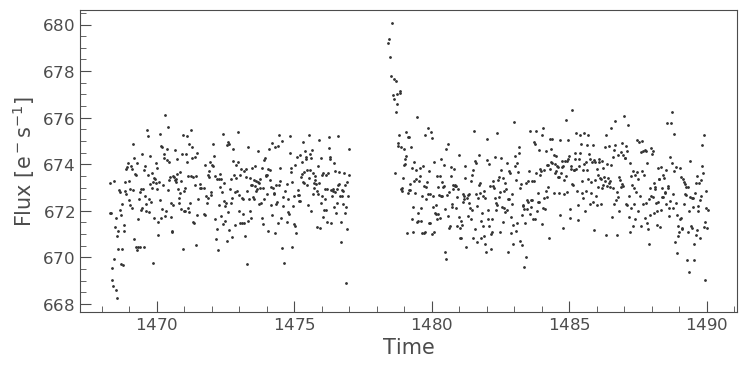

In [765]:
lc_el.remove_outliers().scatter(normalize=False)

## my aperture

In [766]:
new_aper = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [767]:
data.get_lightcurve(aperture=new_aper)

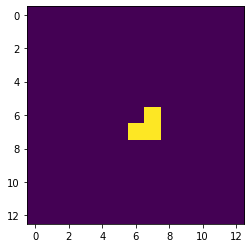

In [768]:
plt.imshow(data.aperture)

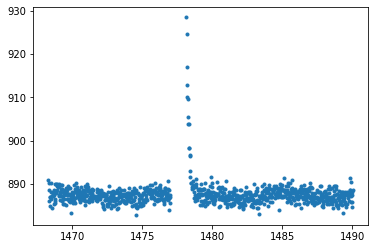

In [769]:
plt.plot(data.time[q], data.corr_flux[q], '.')

In [770]:
lc_my = lk.LightCurve(data.time[q], data.corr_flux[q])

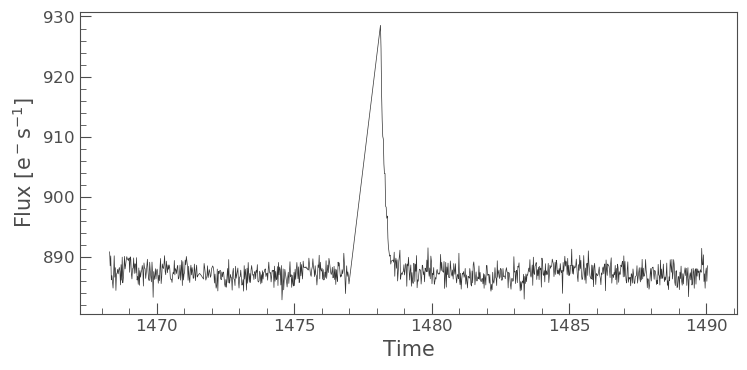

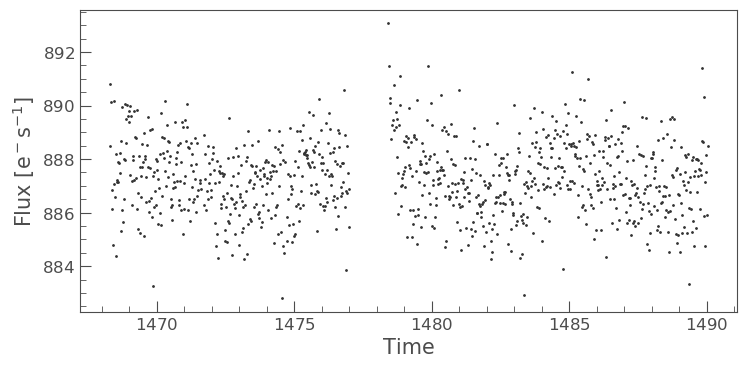

In [771]:
lc_my.plot(normalize=False)
lc_my.remove_outliers().scatter(normalize=False)

### Compare CDPPs of both aperture lcs

In [772]:
lc_el.remove_outliers().estimate_cdpp()

582.0413185727043

In [773]:
np.sqrt(sum((lc_el.remove_outliers().flux - np.mean(lc_el.remove_outliers().flux))**2))

44.32333179323241

In [774]:
lc_my.remove_outliers().estimate_cdpp()

394.1664805401357

In [775]:
np.sqrt(sum((lc_my.remove_outliers().flux - np.mean(lc_my.remove_outliers().flux))**2))

42.85696998154452

In [776]:
#my aperture is "better" lol

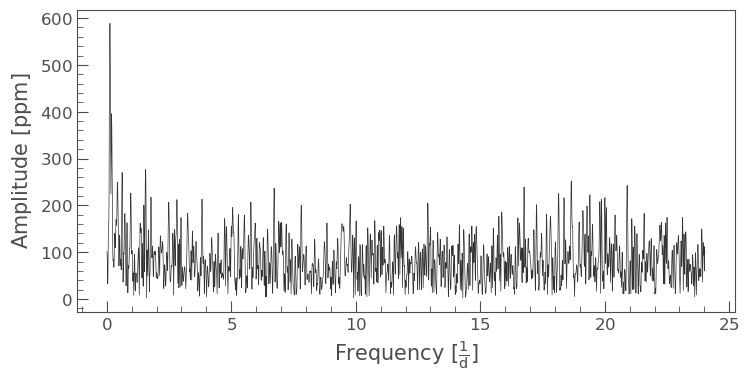

In [777]:
lc_my.remove_outliers().to_periodogram().plot()

# smurfs

In [778]:
from smurfs import Smurfs

 Searching processed light curves for TIC 143169638 ... 
 No light curve found using light kurve. Checking TESS FFIs ... 
 Extracting light curves from FFIs, this may take a bit ...  
 Found star in Sector(s) 6
Found star in Sector(s) 6 
 Extracted light curve for TIC 143169638! 
 Total observation length: 21.75 days. 
 Duty cycle for TIC 143169638: 93.01% 


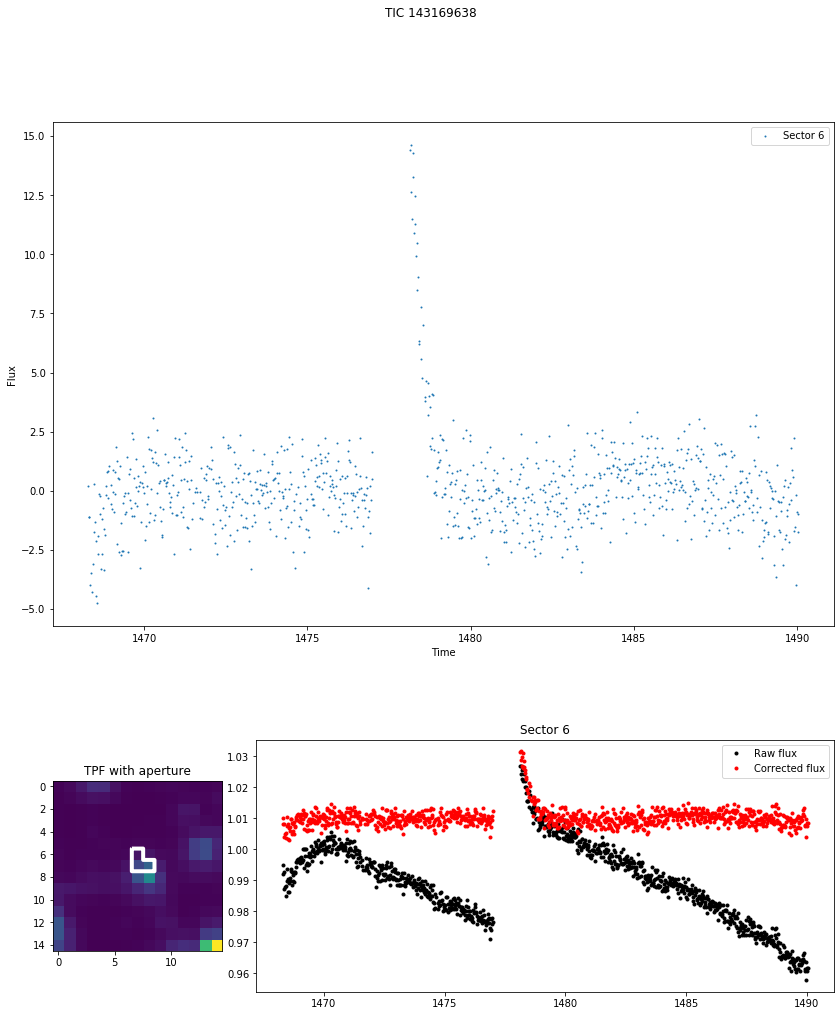

In [779]:
star = Smurfs(target_name='TIC 143169638')